# Federated Learning for Privacy Preservation with Differential Privacy Protocol 

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, datasets
from tensorflow.keras.optimizers import SGD
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


def transform(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    image = (image - 0.5) / 0.5
    return image, label

class SimpleModel(tf.keras.Model):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.flatten = layers.Flatten(input_shape=(28, 28))
        self.fc = layers.Dense(128, activation='relu')
        self.out = layers.Dense(10, activation='softmax')

    def call(self, x):
        x = self.flatten(x)
        x = self.fc(x)
        return self.out(x)

def train_model(model, train_set):
    batch_size = 64
    num_epochs = 10

    train_loader = train_set.batch(batch_size)

    model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.fit(train_loader, epochs=num_epochs)
    print("Training complete")

def evaluate_model(model, test_set):
    test_loader = test_set.batch(64)

    loss, accuracy = model.evaluate(test_loader)
    return loss, accuracy

def include_digits(dataset, included_digits):
    def filter_fn(x, y):
        return tf.reduce_any(tf.equal(y, included_digits))

    return dataset.filter(filter_fn)

def exclude_digits(dataset, excluded_digits):
    def filter_fn(x, y):
        return tf.reduce_all(tf.not_equal(y, excluded_digits))

    return dataset.filter(filter_fn)

def plot_distribution(dataset, title):
    labels = [y.numpy() for _, y in dataset]
    labels = np.array(labels)

    unique_labels, label_counts = np.unique(labels, return_counts=True)

    plt.figure(figsize=(4, 2))

    counts_dict = {
        label: count for label, count in zip(unique_labels, label_counts)
    }

    all_labels = np.arange(10)
    all_label_counts = [counts_dict.get(label, 0) for label in all_labels]

    plt.bar(all_labels, all_label_counts)
    plt.title(title)
    plt.xlabel("Digit")
    plt.ylabel("Count")
    plt.xticks(all_labels)
    plt.show()

def compute_confusion_matrix(model, test_set, batch_size=64):
    true_labels = []
    predicted_labels = []

    # This is a DataLoader-like generator for batching
    def batch_generator(test_set, batch_size):
        batch_images = []
        batch_labels = []
        for image, label in test_set:
            batch_images.append(image)
            batch_labels.append(label)
            if len(batch_images) == batch_size:
                yield (np.array(batch_images), np.array(batch_labels))
                batch_images = []
                batch_labels = []
        # Yields the last batch if it's smaller than batch_size
        if batch_images:
            yield (np.array(batch_images), np.array(batch_labels))

    for batch_images, batch_labels in batch_generator(test_set, batch_size):
        batch_images = tf.convert_to_tensor(batch_images)
        batch_labels = tf.convert_to_tensor(batch_labels)

        # Forward pass through the model to get predictions
        output = model.predict(batch_images)  # Model expects a batch of images
        predictions = np.argmax(output, axis=1)

        true_labels.extend(batch_labels.numpy())
        predicted_labels.extend(predictions)

    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)

    cm = confusion_matrix(true_labels, predicted_labels)

    return cm

def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", linewidths=0.5)
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()
trainset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).map(transform)
testset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).map(transform)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
total_length = len(train_images)
split_size = total_length // 3
tf.random.set_seed(42)
part1, part2, part3 = (train_images[:split_size], train_labels[:split_size]), \
                      (train_images[split_size:2*split_size], train_labels[split_size:2*split_size]), \
                      (train_images[2*split_size:], train_labels[2*split_size:])

In [4]:
part1 = tf.data.Dataset.from_tensor_slices(part1).map(transform)
part2 = tf.data.Dataset.from_tensor_slices(part2).map(transform)
part3 = tf.data.Dataset.from_tensor_slices(part3).map(transform)

part1 = exclude_digits(part1, excluded_digits=[1, 3, 7])
part2 = exclude_digits(part2, excluded_digits=[2, 5, 8])
part3 = exclude_digits(part3, excluded_digits=[4, 6, 9])

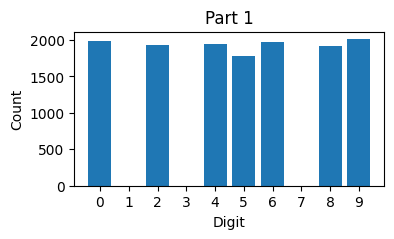

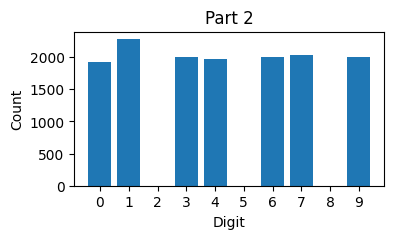

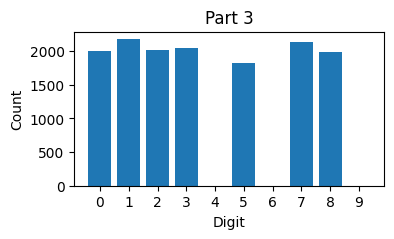

In [5]:
plot_distribution(part1, "Part 1")
plot_distribution(part2, "Part 2")
plot_distribution(part3, "Part 3")

In [6]:
model1 = SimpleModel()
train_model(model1, part1)

model2 = SimpleModel()
train_model(model2, part2)

model3 = SimpleModel()
train_model(model3, part3)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1735222790.818125      95 service.cc:145] XLA service 0x7e190800edb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735222790.818182      95 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1735222790.818190      95 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


     29/Unknown 2s 6ms/step - accuracy: 0.3529 - loss: 2.0671

I0000 00:00:1735222791.965215      95 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


212/212 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7251 - loss: 0.8532
Epoch 2/10
 31/212 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9334 - loss: 0.2278

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9300 - loss: 0.2283
Epoch 3/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9437 - loss: 0.1788
Epoch 4/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9596 - loss: 0.1370
Epoch 5/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9674 - loss: 0.1116
Epoch 6/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9718 - loss: 0.0946
Epoch 7/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9767 - loss: 0.0805
Epoch 8/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9800 - loss: 0.0688
Epoch 9/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9830 - loss: 0.0595
Epoch 10/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9859 - loss: 0.0522
Training complete
Epoch 1/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7792 - loss: 0.6583
Epoch 2/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9456 - loss: 0.1817
Epoch 3/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms

In [7]:
testset_137 = include_digits(testset, included_digits=[1, 3, 7])
testset_258 = include_digits(testset, included_digits=[2, 5, 8])
testset_469 = include_digits(testset, included_digits=[4, 6, 9])


In [8]:
_, accuracy1 = evaluate_model(model1, testset)
_, accuracy1_on_137 = evaluate_model(model1, testset_137)
print(
    f"Model 1-> Test Accuracy on all digits: {accuracy1:.4f}, "
    f"Test Accuracy on [1,3,7]: {accuracy1_on_137:.4f}"
)

_, accuracy2 = evaluate_model(model2, testset)
_, accuracy2_on_258 = evaluate_model(model2, testset_258)
print(
    f"Model 2-> Test Accuracy on all digits: {accuracy2:.4f}, "
    f"Test Accuracy on [2,5,8]: {accuracy2_on_258:.4f}"
)

_, accuracy3 = evaluate_model(model3, testset)
_, accuracy3_on_469 = evaluate_model(model3, testset_469)
print(
    f"Model 3-> Test Accuracy on all digits: {accuracy3:.4f}, "
    f"Test Accuracy on [4,6,9]: {accuracy3_on_469:.4f}"
)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6501 - loss: 4.3047
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 13.1841
Model 1-> Test Accuracy on all digits: 0.6578, Test Accuracy on [1,3,7]: 0.0000
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6778 - loss: 3.5303
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 11.8106
Model 2-> Test Accuracy on all digits: 0.6852, Test Accuracy on [2,5,8]: 0.0000
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6720 - loss: 3.4756
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 11.3564
Model 3-> Test Accuracy on all digits: 0.6790, Test Accuracy on [4,6,9]: 0.0000


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━

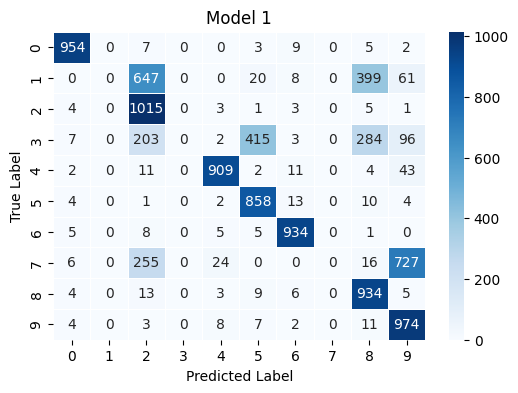

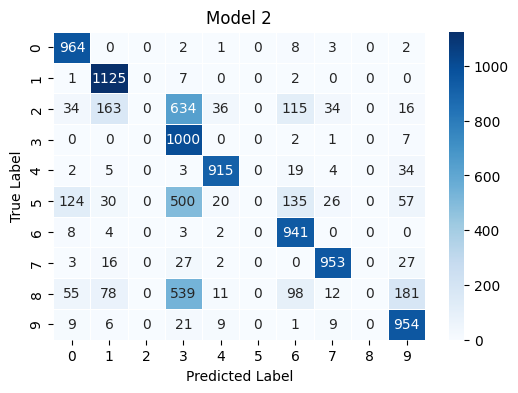

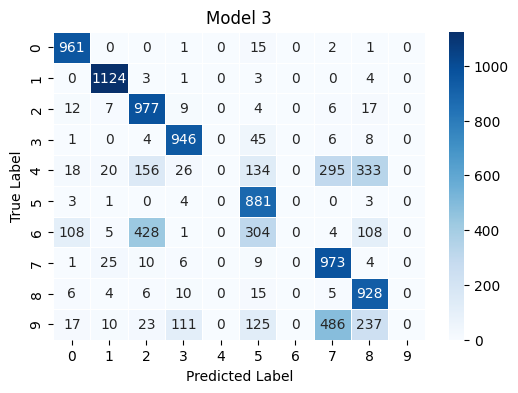

In [9]:
confusion_matrix_model1_all = compute_confusion_matrix(model1, testset);
confusion_matrix_model2_all = compute_confusion_matrix(model2, testset);
confusion_matrix_model3_all = compute_confusion_matrix(model3, testset);

plot_confusion_matrix(confusion_matrix_model1_all, "Model 1")
plot_confusion_matrix(confusion_matrix_model2_all, "Model 2")
plot_confusion_matrix(confusion_matrix_model3_all, "Model 3")

# Introducing Federated Learning

In [10]:
pip install flwr

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 523.6/523.6 kB 10.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 3.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
  Attempting uninstall: typer
    Found existing installation: typer 0.12.3
    Uninstalling typer-0.12.3:
      Successfully uninstalled typer-0.12.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.46.0 requires cloudpickle~=2.2.1, but you have cloudpickle 3.0.0 which is incompatible.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have

In [11]:
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import ndarrays_to_parameters, Context
from flwr.server import ServerApp, ServerConfig
from flwr.server import ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation

from collections import OrderedDict
from typing import List, Tuple, Dict, Optional
from flwr.common import Metrics, NDArrays, Scalar
import torch
import torch.nn as nn
from torch.utils.data import Subset, DataLoader, random_split
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import logging
from flwr.common.logger import console_handler, log
from logging import INFO, ERROR


class InfoFilter(logging.Filter):
    def filter(self, record):
        return record.levelno == INFO


console_handler.setLevel(INFO)
console_handler.addFilter(InfoFilter())

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)



from logging import ERROR
backend_setup = {"init_args": {"logging_level": ERROR, "log_to_driver": False}}


class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc = nn.Linear(784, 128)
        self.relu = nn.ReLU()
        self.out = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc(x)
        x = self.relu(x)
        x = self.out(x)
        return x


def train_model(model, train_set):
    batch_size = 64
    num_epochs = 10

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()


def evaluate_model(model, test_set):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0

    test_loader = DataLoader(test_set, batch_size=64, shuffle=False)
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loss = criterion(outputs, labels)
            total_loss += loss.item()

    accuracy = correct / total
    average_loss = total_loss / len(test_loader)
    # print(f"Test Accuracy: {accuracy:.4f}, Average Loss: {average_loss:.4f}")
    return average_loss, accuracy


def include_digits(dataset, included_digits):
    including_indices = [
        idx for idx in range(len(dataset)) if dataset[idx][1] in included_digits
    ]
    return torch.utils.data.Subset(dataset, including_indices)


def exclude_digits(dataset, excluded_digits):
    including_indices = [
        idx for idx in range(len(dataset)) if dataset[idx][1] not in excluded_digits
    ]
    return torch.utils.data.Subset(dataset, including_indices)


def compute_confusion_matrix(model, testset):
    # Initialize lists to store true labels and predicted labels
    true_labels = []
    predicted_labels = []

    # Iterate over the test set to get predictions
    for image, label in testset:
        # Forward pass through the model to get predictions
        output = model(image.unsqueeze(0))  # Add batch dimension
        _, predicted = torch.max(output, 1)

        true_labels.append(label)
        predicted_labels.append(predicted.item())

    # Convert lists to numpy arrays
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    return cm


def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", linewidths=0.5)
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()


2024-12-26 14:23:06,767	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [12]:
trainset = datasets.MNIST(
    "./MNIST_data/", download=True, train=True, transform=transform
)

total_length = len(trainset)
split_size = total_length // 3
torch.manual_seed(42)
part1, part2, part3 = random_split(trainset, [split_size] * 3)

part1 = exclude_digits(part1, excluded_digits=[1, 3, 7])
part2 = exclude_digits(part2, excluded_digits=[2, 5, 8])
part3 = exclude_digits(part3, excluded_digits=[4, 6, 9])

train_sets = [part1, part2, part3]

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 42608585.98it/s]


Extracting ./MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1154618.96it/s]


Extracting ./MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 10785890.47it/s]


Extracting ./MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2566073.38it/s]


Extracting ./MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw



In [13]:
testset = datasets.MNIST(
    "./MNIST_data/", download=True, train=False, transform=transform
)
print("Number of examples in `testset`:", len(testset))

testset_137 = include_digits(testset, [1, 3, 7])
testset_258 = include_digits(testset, [2, 5, 8])
testset_469 = include_digits(testset, [4, 6, 9])

Number of examples in `testset`: 10000


In [14]:
# Setting the parameters of the model
def set_weights(net, parameters):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict(
        {k: torch.tensor(v) for k, v in params_dict}
    )
    net.load_state_dict(state_dict, strict=True)

# Retrieves the parameters from the model
def get_weights(net):
    ndarrays = [
        val.cpu().numpy() for _, val in net.state_dict().items()
    ]
    return ndarrays

In [15]:
class FlowerClient(NumPyClient):
    def __init__(self, net, trainset, testset):
        self.net = net
        self.trainset = trainset
        self.testset = testset

    # Train the model
    def fit(self, parameters, config):
        set_weights(self.net, parameters)
        train_model(self.net, self.trainset)
        return get_weights(self.net), len(self.trainset), {}

    # Test the model
    def evaluate(self, parameters: NDArrays, config: Dict[str, Scalar]):
        set_weights(self.net, parameters)
        loss, accuracy = evaluate_model(self.net, self.testset)
        return loss, len(self.testset), {"accuracy": accuracy}

In [16]:
# Client function
def client_fn(context: Context) -> Client:
    net = SimpleModel()
    partition_id = int(context.node_config["partition-id"])
    client_train = train_sets[int(partition_id)]
    client_test = testset
    return FlowerClient(net, client_train, client_test).to_client()

In [17]:
client = ClientApp(client_fn)

In [18]:
def evaluate(server_round, parameters, config):
    net = SimpleModel()
    set_weights(net, parameters)

    _, accuracy = evaluate_model(net, testset)
    _, accuracy137 = evaluate_model(net, testset_137)
    _, accuracy258 = evaluate_model(net, testset_258)
    _, accuracy469 = evaluate_model(net, testset_469)

    log(INFO, "test accuracy on all digits: %.4f", accuracy)
    log(INFO, "test accuracy on [1,3,7]: %.4f", accuracy137)
    log(INFO, "test accuracy on [2,5,8]: %.4f", accuracy258)
    log(INFO, "test accuracy on [4,6,9]: %.4f", accuracy469)

    if server_round == 3:
        cm = compute_confusion_matrix(net, testset)
        plot_confusion_matrix(cm, "Final Global Model")

In [19]:
net = SimpleModel()
params = ndarrays_to_parameters(get_weights(net))

def server_fn(context: Context):
    strategy = FedAvg(
        fraction_fit=1.0,
        fraction_evaluate=0.0,
        initial_parameters=params,
        evaluate_fn=evaluate,
    )
    config=ServerConfig(num_rounds=3)
    return ServerAppComponents(
        strategy=strategy,
        config=config,
    )

In [20]:
server = ServerApp(server_fn=server_fn)

INFO :      Starting Flower ServerApp, config: num_rounds=3, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
/opt/conda/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
/opt/conda/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
INFO :      test accuracy on all digits: 0.1267
INFO :      test accuracy on [1,3,7]: 0.2275
INFO :      test accuracy on [2,5,8]: 0.1201
INFO :      test accuracy on [4,6,9]: 0.0380
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :    

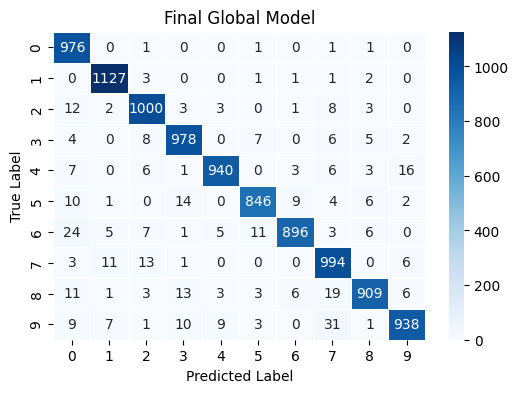

INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 3 round(s) in 256.63s
INFO :      


In [21]:
# Initiate the simulation passing the server and client apps
# Specify the number of super nodes that will be selected on every round
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=3,
    backend_config=backend_setup,
)

# Integration of Differential privacy

Number of examples in `testset`: 10000


INFO :      Starting Flower ServerApp, config: num_rounds=3, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
/opt/conda/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
INFO :      test accuracy on all digits: 0.1267
INFO :      test accuracy on [1,3,7]: 0.2275
INFO :      test accuracy on [2,5,8]: 0.1201
INFO :      test accuracy on [4,6,9]: 0.0380
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      test accuracy on all digits: 0.2330
INFO :      test accuracy on [1,3,7]: 0.2020
INFO :      test accuracy on [2,5

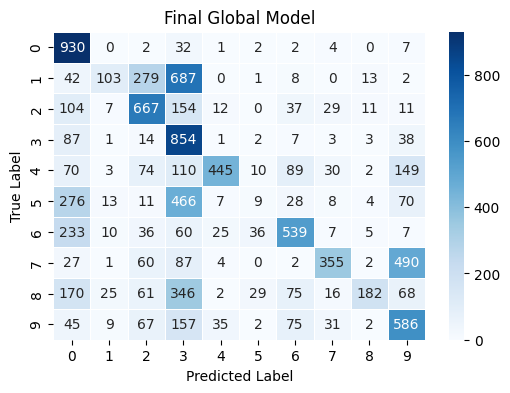

INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 3 round(s) in 266.84s
INFO :      


In [22]:
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import ndarrays_to_parameters, Context
from flwr.server import ServerApp, ServerConfig
from flwr.server import ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation

from collections import OrderedDict
from typing import List, Tuple, Dict, Optional
from flwr.common import Metrics, NDArrays, Scalar
import torch
import torch.nn as nn
from torch.utils.data import Subset, DataLoader, random_split
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import logging
from flwr.common.logger import console_handler, log
from logging import INFO, ERROR


class InfoFilter(logging.Filter):
    def filter(self, record):
        return record.levelno == INFO


console_handler.setLevel(INFO)
console_handler.addFilter(InfoFilter())

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)


from logging import ERROR
backend_setup = {"init_args": {"logging_level": ERROR, "log_to_driver": False}}

class DPConfig:
    def __init__(self, noise_multiplier=1.0, clip_value=1.0):
        self.noise_multiplier = noise_multiplier
        self.clip_value = clip_value

dp_config = DPConfig(noise_multiplier=0.5, clip_value=1.0)  # I need to adjust this later on as needed


class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc = nn.Linear(784, 128)
        self.relu = nn.ReLU()
        self.out = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc(x)
        x = self.relu(x)
        x = self.out(x)
        return x


def train_model(model, train_set, dp_config):
    batch_size = 64
    num_epochs = 10

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            # Here I am clipping gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), dp_config.clip_value)

            # At this point, I am adding Gaussian noise to gradients
            for param in model.parameters():
                if param.grad is not None:
                    noise = torch.randn(param.grad.shape) * dp_config.noise_multiplier
                    param.grad += noise

            optimizer.step()
            running_loss += loss.item()


def evaluate_model(model, test_set):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0

    test_loader = DataLoader(test_set, batch_size=64, shuffle=False)
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loss = criterion(outputs, labels)
            total_loss += loss.item()

    accuracy = correct / total
    average_loss = total_loss / len(test_loader)
    # print(f"Test Accuracy: {accuracy:.4f}, Average Loss: {average_loss:.4f}")
    return average_loss, accuracy


def include_digits(dataset, included_digits):
    including_indices = [
        idx for idx in range(len(dataset)) if dataset[idx][1] in included_digits
    ]
    return torch.utils.data.Subset(dataset, including_indices)


def exclude_digits(dataset, excluded_digits):
    including_indices = [
        idx for idx in range(len(dataset)) if dataset[idx][1] not in excluded_digits
    ]
    return torch.utils.data.Subset(dataset, including_indices)


def compute_confusion_matrix(model, testset):
    # Initialize lists to store true labels and predicted labels
    true_labels = []
    predicted_labels = []

    # Iterate over the test set to get predictions
    for image, label in testset:
        # I am making a forward pass through the model to get predictions
        output = model(image.unsqueeze(0))  # Add batch dimension
        _, predicted = torch.max(output, 1)

        # Appending true and predicted labels to lists
        true_labels.append(label)
        predicted_labels.append(predicted.item())

    # I am converting lists to numpy arrays
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    return cm


def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", linewidths=0.5)
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

trainset = datasets.MNIST(
    "./MNIST_data/", download=True, train=True, transform=transform
)

total_length = len(trainset)
split_size = total_length // 3
torch.manual_seed(42)
part1, part2, part3 = random_split(trainset, [split_size] * 3)

part1 = exclude_digits(part1, excluded_digits=[1, 3, 7])
part2 = exclude_digits(part2, excluded_digits=[2, 5, 8])
part3 = exclude_digits(part3, excluded_digits=[4, 6, 9])

train_sets = [part1, part2, part3]

testset = datasets.MNIST(
    "./MNIST_data/", download=True, train=False, transform=transform
)
print("Number of examples in `testset`:", len(testset))

testset_137 = include_digits(testset, [1, 3, 7])
testset_258 = include_digits(testset, [2, 5, 8])
testset_469 = include_digits(testset, [4, 6, 9])

# Sets the parameters of the model
def set_weights(net, parameters):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict(
        {k: torch.tensor(v) for k, v in params_dict}
    )
    net.load_state_dict(state_dict, strict=True)

# Retrieves the parameters from the model
def get_weights(net):
    ndarrays = [
        val.cpu().numpy() for _, val in net.state_dict().items()
    ]
    return ndarrays

class FlowerClient(NumPyClient):
    def __init__(self, net, trainset, testset, dp_config):
        self.net = net
        self.trainset = trainset
        self.testset = testset
        self.dp_config = dp_config

    # Train the model
    def fit(self, parameters, config):
        set_weights(self.net, parameters)
        train_model(self.net, self.trainset, self.dp_config)
        return get_weights(self.net), len(self.trainset), {}

    # Test the model
    def evaluate(self, parameters: NDArrays, config: Dict[str, Scalar]):
        set_weights(self.net, parameters)
        loss, accuracy = evaluate_model(self.net, self.testset)
        return loss, len(self.testset), {"accuracy": accuracy}

# Client function
def client_fn(context: Context) -> Client:
    net = SimpleModel()
    partition_id = int(context.node_config["partition-id"])
    client_train = train_sets[int(partition_id)]
    client_test = testset
    return FlowerClient(net, client_train, client_test, dp_config).to_client()
client = ClientApp(client_fn)

def evaluate(server_round, parameters, config):
    net = SimpleModel()
    set_weights(net, parameters)

    _, accuracy = evaluate_model(net, testset)
    _, accuracy137 = evaluate_model(net, testset_137)
    _, accuracy258 = evaluate_model(net, testset_258)
    _, accuracy469 = evaluate_model(net, testset_469)

    log(INFO, "test accuracy on all digits: %.4f", accuracy)
    log(INFO, "test accuracy on [1,3,7]: %.4f", accuracy137)
    log(INFO, "test accuracy on [2,5,8]: %.4f", accuracy258)
    log(INFO, "test accuracy on [4,6,9]: %.4f", accuracy469)

    if server_round == 3:
        cm = compute_confusion_matrix(net, testset)
        plot_confusion_matrix(cm, "Final Global Model")
        
net = SimpleModel()
params = ndarrays_to_parameters(get_weights(net))

def server_fn(context: Context):
    strategy = FedAvg(
        fraction_fit=1.0,
        fraction_evaluate=0.0,
        initial_parameters=params,
        evaluate_fn=evaluate,
    )
    config=ServerConfig(num_rounds=3)
    return ServerAppComponents(
        strategy=strategy,
        config=config,
    )

server = ServerApp(server_fn=server_fn)

# Running the simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=3,
    backend_config=backend_setup,
)

# Tuning the Hyperparameters

Number of examples in `testset`: 10000


INFO :      Starting Flower ServerApp, config: num_rounds=3, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
/opt/conda/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
INFO :      test accuracy on all digits: 0.1267
INFO :      test accuracy on [1,3,7]: 0.2275
INFO :      test accuracy on [2,5,8]: 0.1201
INFO :      test accuracy on [4,6,9]: 0.0380
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      test accuracy on all digits: 0.8625
INFO :      test accuracy on [1,3,7]: 0.9458
INFO :      test accuracy on [2,5

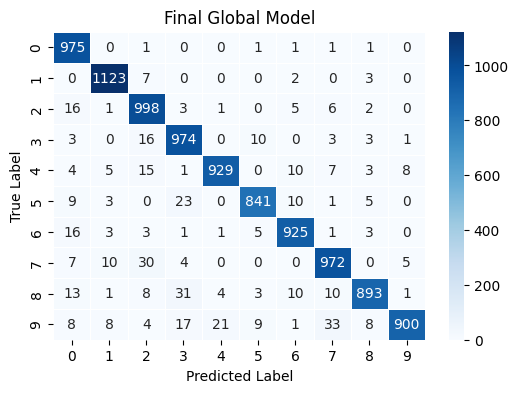

INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 3 round(s) in 266.67s
INFO :      


In [23]:
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import ndarrays_to_parameters, Context
from flwr.server import ServerApp, ServerConfig
from flwr.server import ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation

from collections import OrderedDict
from typing import List, Tuple, Dict, Optional
from flwr.common import Metrics, NDArrays, Scalar
import torch
import torch.nn as nn
from torch.utils.data import Subset, DataLoader, random_split
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import logging
from flwr.common.logger import console_handler, log
from logging import INFO, ERROR


class InfoFilter(logging.Filter):
    def filter(self, record):
        return record.levelno == INFO


console_handler.setLevel(INFO)
console_handler.addFilter(InfoFilter())

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)


from logging import ERROR
backend_setup = {"init_args": {"logging_level": ERROR, "log_to_driver": False}}

class DPConfig:
    def __init__(self, noise_multiplier=1.0, clip_value=1.0):
        self.noise_multiplier = noise_multiplier
        self.clip_value = clip_value

dp_config = DPConfig(noise_multiplier=0.01, clip_value=2.0)  # I need to adjust this later on as needed


class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc = nn.Linear(784, 128)
        self.relu = nn.ReLU()
        self.out = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc(x)
        x = self.relu(x)
        x = self.out(x)
        return x


def train_model(model, train_set, dp_config):
    batch_size = 64
    num_epochs = 10

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            # Here I am clipping gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), dp_config.clip_value)

            # At this point, I am adding Gaussian noise to gradients
            for param in model.parameters():
                if param.grad is not None:
                    noise = torch.randn(param.grad.shape) * dp_config.noise_multiplier
                    param.grad += noise

            optimizer.step()
            running_loss += loss.item()


def evaluate_model(model, test_set):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0

    test_loader = DataLoader(test_set, batch_size=64, shuffle=False)
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loss = criterion(outputs, labels)
            total_loss += loss.item()

    accuracy = correct / total
    average_loss = total_loss / len(test_loader)
    # print(f"Test Accuracy: {accuracy:.4f}, Average Loss: {average_loss:.4f}")
    return average_loss, accuracy


def include_digits(dataset, included_digits):
    including_indices = [
        idx for idx in range(len(dataset)) if dataset[idx][1] in included_digits
    ]
    return torch.utils.data.Subset(dataset, including_indices)


def exclude_digits(dataset, excluded_digits):
    including_indices = [
        idx for idx in range(len(dataset)) if dataset[idx][1] not in excluded_digits
    ]
    return torch.utils.data.Subset(dataset, including_indices)


def compute_confusion_matrix(model, testset):
    # Initialize lists to store true labels and predicted labels
    true_labels = []
    predicted_labels = []

    # Iterate over the test set to get predictions
    for image, label in testset:
        # I am making a forward pass through the model to get predictions
        output = model(image.unsqueeze(0))  # Add batch dimension
        _, predicted = torch.max(output, 1)

        # Appending true and predicted labels to lists
        true_labels.append(label)
        predicted_labels.append(predicted.item())

    # I am converting lists to numpy arrays
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    return cm


def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", linewidths=0.5)
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

trainset = datasets.MNIST(
    "./MNIST_data/", download=True, train=True, transform=transform
)

total_length = len(trainset)
split_size = total_length // 3
torch.manual_seed(42)
part1, part2, part3 = random_split(trainset, [split_size] * 3)

part1 = exclude_digits(part1, excluded_digits=[1, 3, 7])
part2 = exclude_digits(part2, excluded_digits=[2, 5, 8])
part3 = exclude_digits(part3, excluded_digits=[4, 6, 9])

train_sets = [part1, part2, part3]

testset = datasets.MNIST(
    "./MNIST_data/", download=True, train=False, transform=transform
)
print("Number of examples in `testset`:", len(testset))

testset_137 = include_digits(testset, [1, 3, 7])
testset_258 = include_digits(testset, [2, 5, 8])
testset_469 = include_digits(testset, [4, 6, 9])

# Sets the parameters of the model
def set_weights(net, parameters):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict(
        {k: torch.tensor(v) for k, v in params_dict}
    )
    net.load_state_dict(state_dict, strict=True)

# Retrieves the parameters from the model
def get_weights(net):
    ndarrays = [
        val.cpu().numpy() for _, val in net.state_dict().items()
    ]
    return ndarrays

class FlowerClient(NumPyClient):
    def __init__(self, net, trainset, testset, dp_config):
        self.net = net
        self.trainset = trainset
        self.testset = testset
        self.dp_config = dp_config

    # Train the model
    def fit(self, parameters, config):
        set_weights(self.net, parameters)
        train_model(self.net, self.trainset, self.dp_config)
        return get_weights(self.net), len(self.trainset), {}

    # Test the model
    def evaluate(self, parameters: NDArrays, config: Dict[str, Scalar]):
        set_weights(self.net, parameters)
        loss, accuracy = evaluate_model(self.net, self.testset)
        return loss, len(self.testset), {"accuracy": accuracy}

# Client function
def client_fn(context: Context) -> Client:
    net = SimpleModel()
    partition_id = int(context.node_config["partition-id"])
    client_train = train_sets[int(partition_id)]
    client_test = testset
    return FlowerClient(net, client_train, client_test, dp_config).to_client()
client = ClientApp(client_fn)

def evaluate(server_round, parameters, config):
    net = SimpleModel()
    set_weights(net, parameters)

    _, accuracy = evaluate_model(net, testset)
    _, accuracy137 = evaluate_model(net, testset_137)
    _, accuracy258 = evaluate_model(net, testset_258)
    _, accuracy469 = evaluate_model(net, testset_469)

    log(INFO, "test accuracy on all digits: %.4f", accuracy)
    log(INFO, "test accuracy on [1,3,7]: %.4f", accuracy137)
    log(INFO, "test accuracy on [2,5,8]: %.4f", accuracy258)
    log(INFO, "test accuracy on [4,6,9]: %.4f", accuracy469)

    if server_round == 3:
        cm = compute_confusion_matrix(net, testset)
        plot_confusion_matrix(cm, "Final Global Model")
        
net = SimpleModel()
params = ndarrays_to_parameters(get_weights(net))

def server_fn(context: Context):
    strategy = FedAvg(
        fraction_fit=1.0,
        fraction_evaluate=0.0,
        initial_parameters=params,
        evaluate_fn=evaluate,
    )
    config=ServerConfig(num_rounds=3)
    return ServerAppComponents(
        strategy=strategy,
        config=config,
    )

server = ServerApp(server_fn=server_fn)

# Running the simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=3,
    backend_config=backend_setup,
)

# Finding Precision, Recall and F1 Score

INFO :      Starting Flower ServerApp, config: num_rounds=3, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
/opt/conda/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: no clients selected, skipping evaluation
IN

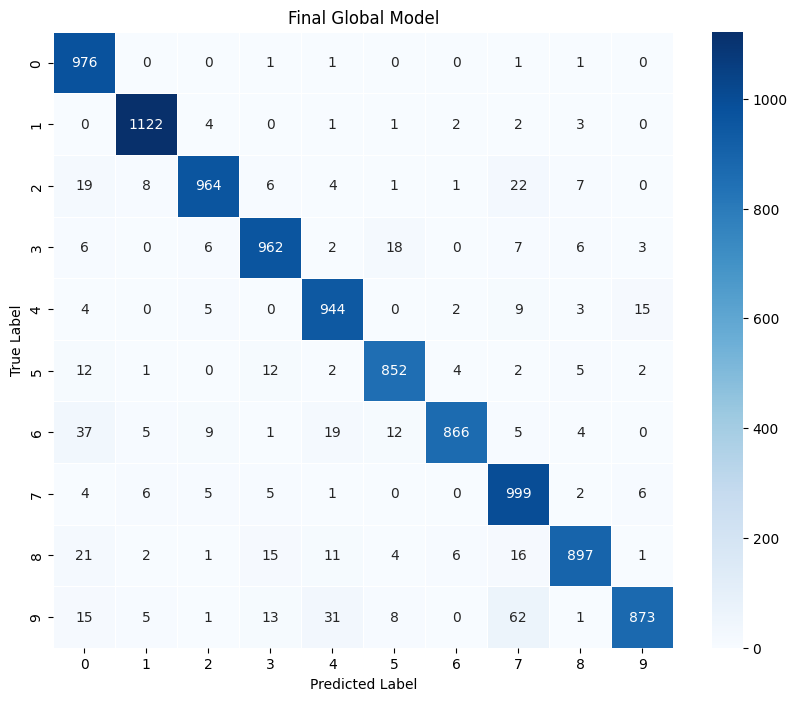

INFO :      configure_evaluate: no clients selected, skipping evaluation
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 3 round(s) in 244.79s
INFO :      



Precision, Recall, and F1-Score for each class:
Class	Precision	Recall	F1-Score
0	0.8921	0.9959	0.9412
1	0.9765	0.9885	0.9825
2	0.9688	0.9341	0.9512
3	0.9478	0.9525	0.9501
4	0.9291	0.9613	0.9449
5	0.9509	0.9552	0.9530
6	0.9830	0.9040	0.9418
7	0.8880	0.9718	0.9280
8	0.9656	0.9209	0.9427
9	0.9700	0.8652	0.9146


In [25]:
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import ndarrays_to_parameters, Context
from flwr.server import ServerApp, ServerConfig
from flwr.server import ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation

from collections import OrderedDict
from typing import List, Tuple, Dict, Optional
from flwr.common import Metrics, NDArrays, Scalar
import torch
import torch.nn as nn
from torch.utils.data import Subset, DataLoader, random_split
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import logging
from flwr.common.logger import console_handler, log
from logging import INFO, ERROR

# Logger setup
class InfoFilter(logging.Filter):
    def filter(self, record):
        return record.levelno == INFO

console_handler.setLevel(INFO)
console_handler.addFilter(InfoFilter())

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

backend_setup = {"init_args": {"logging_level": ERROR, "log_to_driver": False}}

# Differential Privacy configuration
class DPConfig:
    def __init__(self, noise_multiplier=1.0, clip_value=1.0):
        self.noise_multiplier = noise_multiplier
        self.clip_value = clip_value

dp_config = DPConfig(noise_multiplier=0.01, clip_value=2.0)

# Simple model
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc = nn.Linear(784, 128)
        self.relu = nn.ReLU()
        self.out = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc(x)
        x = self.relu(x)
        x = self.out(x)
        return x

# Model training
def train_model(model, train_set, dp_config):
    batch_size = 64
    num_epochs = 10
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    model.train()
    for epoch in range(num_epochs):
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), dp_config.clip_value)

            for param in model.parameters():
                if param.grad is not None:
                    noise = torch.randn(param.grad.shape) * dp_config.noise_multiplier
                    param.grad += noise

            optimizer.step()

# Model evaluation
def evaluate_model(model, test_set):
    model.eval()
    correct, total, total_loss = 0, 0, 0
    test_loader = DataLoader(test_set, batch_size=64, shuffle=False)
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = criterion(outputs, labels)
            total_loss += loss.item()

    return total_loss / len(test_loader), correct / total

# Dataset utilities
def include_digits(dataset, included_digits):
    including_indices = [
        idx for idx in range(len(dataset)) if dataset[idx][1] in included_digits
    ]
    return torch.utils.data.Subset(dataset, including_indices)

def exclude_digits(dataset, excluded_digits):
    including_indices = [
        idx for idx in range(len(dataset)) if dataset[idx][1] not in excluded_digits
    ]
    return torch.utils.data.Subset(dataset, including_indices)

# Confusion matrix and metrics computation
def compute_confusion_matrix_and_metrics(model, testset):
    true_labels, predicted_labels = [], []
    for image, label in testset:
        output = model(image.unsqueeze(0))
        _, predicted = torch.max(output, 1)
        true_labels.append(label)
        predicted_labels.append(predicted.item())

    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)
    cm = confusion_matrix(true_labels, predicted_labels)
    report = classification_report(true_labels, predicted_labels, output_dict=True)

    precision = {k: v["precision"] for k, v in report.items() if k.isdigit()}
    recall = {k: v["recall"] for k, v in report.items() if k.isdigit()}
    f1_score = {k: v["f1-score"] for k, v in report.items() if k.isdigit()}

    return cm, precision, recall, f1_score

def plot_confusion_matrix_and_metrics(cm, precision, recall, f1_score, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", linewidths=0.5)
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    print("\nPrecision, Recall, and F1-Score for each class:")
    print("Class\tPrecision\tRecall\tF1-Score")
    for cls in precision.keys():
        print(f"{cls}\t{precision[cls]:.4f}\t{recall[cls]:.4f}\t{f1_score[cls]:.4f}")

# Train and test datasets
trainset = datasets.MNIST("./MNIST_data/", download=True, train=True, transform=transform)
total_length = len(trainset)
split_size = total_length // 3
torch.manual_seed(42)
part1, part2, part3 = random_split(trainset, [split_size] * 3)
part1 = exclude_digits(part1, excluded_digits=[1, 3, 7])
part2 = exclude_digits(part2, excluded_digits=[2, 5, 8])
part3 = exclude_digits(part3, excluded_digits=[4, 6, 9])
train_sets = [part1, part2, part3]
testset = datasets.MNIST("./MNIST_data/", download=True, train=False, transform=transform)

# Federated Learning setup
class FlowerClient(NumPyClient):
    def __init__(self, net, trainset, testset, dp_config):
        self.net = net
        self.trainset = trainset
        self.testset = testset
        self.dp_config = dp_config

    def fit(self, parameters, config):
        set_weights(self.net, parameters)
        train_model(self.net, self.trainset, self.dp_config)
        return get_weights(self.net), len(self.trainset), {}

    def evaluate(self, parameters, config):
        set_weights(self.net, parameters)
        loss, accuracy = evaluate_model(self.net, self.testset)
        return loss, len(self.testset), {"accuracy": accuracy}

def client_fn(context: Context) -> Client:
    net = SimpleModel()
    partition_id = int(context.node_config["partition-id"])
    client_train = train_sets[int(partition_id)]
    return FlowerClient(net, client_train, testset, dp_config).to_client()

def evaluate(server_round, parameters, config):
    net = SimpleModel()
    set_weights(net, parameters)
    if server_round == 3:
        cm, precision, recall, f1_score = compute_confusion_matrix_and_metrics(net, testset)
        plot_confusion_matrix_and_metrics(cm, precision, recall, f1_score, "Final Global Model")

net = SimpleModel()
params = ndarrays_to_parameters(get_weights(net))
def server_fn(context: Context):
    strategy = FedAvg(fraction_fit=1.0, fraction_evaluate=0.0, initial_parameters=params, evaluate_fn=evaluate)
    return ServerAppComponents(strategy=strategy, config=ServerConfig(num_rounds=3))

server = ServerApp(server_fn=server_fn)
client = ClientApp(client_fn)
run_simulation(server_app=server, client_app=client, num_supernodes=3, backend_config=backend_setup)
